In [363]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image


root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code
from model_src import gabor_feature_extractor
from utils import torch_utils

sys.path.append(os.path.join(root,'toolboxes','texture-synthesis-portilla-simoncelli'))
# import steerable_pyramid

import pyrtools as pt
# this is a package described at https://pyrtools.readthedocs.io/en/latest/

In [36]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [333]:
# Load a grating image (since we know the orientation)
grating_im_file = os.path.join(root,'grating_ims','Grating_ex0_phase0_135deg.png')
im =  Image.open(grating_im_file) 
im = im.convert('L')
npix = 224
im = np.array(im.getdata()).reshape([npix, npix,1])

images = np.expand_dims(np.moveaxis(im, [2],[0]), axis=0)
images.shape

(1, 1, 224, 224)

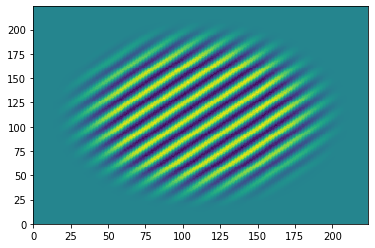

In [362]:
plt.figure();
plt.pcolormesh(image)

In [346]:
# Run the pyramid and also compare to gabor filters.

# choosing just one image here.
image_ind=0
image = images[image_ind,0,:,:]


n_ori=8;
n_sf=4;
padding_mode='circular'

# pyr = pt.pyramids.SteerablePyramidFreq(image, is_complex=True, height = n_sf, order = n_ori-1)
pyr = pt.pyramids.SteerablePyramidFreq(image, is_complex=True, height = n_sf, order = n_ori-1)
print(pyr.num_scales)

# now gabor method...
# choosing values here that will lead to ~ same size maps at each level.
sizevals=[npix]
i=npix
for d in range(n_sf-1):
    i=i/2
    sizevals.append(i)
cyc_per_stim = np.flipud(np.array(sizevals))/4.13
_gaborizer = gabor_feature_extractor.Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode = padding_mode,
          crop=False).to(device)

maps = _gaborizer(torch_utils._to_torch(images[image_ind:image_ind+1,:,:,:], device=device))
maps = [torch_utils.get_value(m) for m in maps]
print(len(maps))

4
4


In [347]:
pyr.pyr_coeffs['residual_lowpass'].dtype

dtype('float64')

In [348]:
pyr.pyr_coeffs['residual_highpass'].dtype

dtype('float64')

In [349]:
pyr.pyr_coeffs[(0,1)].dtype

dtype('complex128')

In [341]:
# what are the orientations that the pyramid filtered at?

orients_pyr_rad = np.array([np.pi*n/pyr.num_orientations for n in range(pyr.num_orientations)])
orients_pyr_deg = orients_pyr_rad*180/np.pi
print(orients_pyr_deg)

print(_gaborizer.orients_deg)

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [342]:
# Approximate the actual cycles/pixel of the frequency bands
# this is based on the idea of stepping down an octave with every level of the pyramid.

freqlist = np.linspace(0.5,0,int(np.floor(npix/2)))

bands = []
ind1 = 0
ind2 = int(np.floor((len(freqlist)-ind1)/2))
print([ind1, ind2])
for bb in range(pyr.num_scales):    
    bands.append([freqlist[ind1],freqlist[ind2]])
    ind1 = ind2
    ind2 = ind2+int(np.floor((len(freqlist)-ind2)/2))
    print([ind1, ind2])
    
bands # range of each frequency band, in cycles/pixel.
print(bands)

# compare to the values from gaborizer method (different because these are a narrower range of SF, not bandpass)
print(np.flipud(cyc_per_stim)/227)

[0, 56]
[56, 84]
[84, 98]
[98, 105]
[105, 108]
[[0.5, 0.24774774774774777], [0.24774774774774777, 0.1216216216216216], [0.1216216216216216, 0.05855855855855857], [0.05855855855855857, 0.02702702702702703]]
[0.23893078 0.11946539 0.0597327  0.02986635]


In [343]:
for ii, key in enumerate(pyr.pyr_coeffs.keys()):
    print('key: ' + str(key))
    print('size: ' + str(pyr.pyr_coeffs[key].shape))

key: residual_highpass
size: (224, 224)
key: (0, 0)
size: (224, 224)
key: (0, 1)
size: (224, 224)
key: (0, 2)
size: (224, 224)
key: (0, 3)
size: (224, 224)
key: (0, 4)
size: (224, 224)
key: (0, 5)
size: (224, 224)
key: (0, 6)
size: (224, 224)
key: (0, 7)
size: (224, 224)
key: (1, 0)
size: (112, 112)
key: (1, 1)
size: (112, 112)
key: (1, 2)
size: (112, 112)
key: (1, 3)
size: (112, 112)
key: (1, 4)
size: (112, 112)
key: (1, 5)
size: (112, 112)
key: (1, 6)
size: (112, 112)
key: (1, 7)
size: (112, 112)
key: (2, 0)
size: (56, 56)
key: (2, 1)
size: (56, 56)
key: (2, 2)
size: (56, 56)
key: (2, 3)
size: (56, 56)
key: (2, 4)
size: (56, 56)
key: (2, 5)
size: (56, 56)
key: (2, 6)
size: (56, 56)
key: (2, 7)
size: (56, 56)
key: (3, 0)
size: (28, 28)
key: (3, 1)
size: (28, 28)
key: (3, 2)
size: (28, 28)
key: (3, 3)
size: (28, 28)
key: (3, 4)
size: (28, 28)
key: (3, 5)
size: (28, 28)
key: (3, 6)
size: (28, 28)
key: (3, 7)
size: (28, 28)
key: residual_lowpass
size: (14, 14)


In [344]:
for m in maps:
    print(m.shape)

(1, 8, 29, 29)
(1, 8, 57, 57)
(1, 8, 113, 113)
(1, 8, 225, 225)


(224, 224)
(112, 112)
(56, 56)
(28, 28)


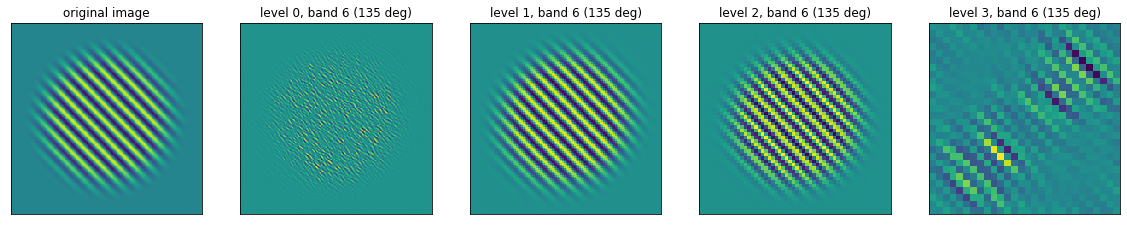

In [345]:
plt.figure(figsize=(24,12));

plt.subplot(1,6,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

sf_bands = [0,1,2,3]
# ori_bands = [2,2,2,2]
ori_bands = [6,6,6,6]
# ori_bands = [0,0,0,0,0]

for ii in range(len(sf_bands)):
    
#     fmap = np.abs(pyr.pyr_coeffs[(sf_bands[ii],ori_bands[ii])])
    fmap = np.real(pyr.pyr_coeffs[(sf_bands[ii],ori_bands[ii])])
    print(fmap.shape)
    plt.subplot(1,6,2+ii)
    plt.pcolormesh(fmap)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('level %d, band %d (%d deg)'%(sf_bands[ii],ori_bands[ii], orients_pyr_deg[ori_bands[ii]]))
#     plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])


(225, 225)
(113, 113)
(57, 57)
(29, 29)


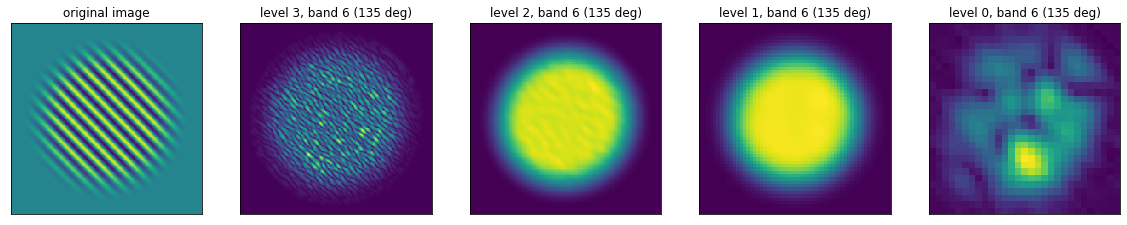

In [232]:
# Plotting first level feature maps

image_ind = 0

orient_labs = _gaborizer.orients_deg
freq_labs = _gaborizer.cyc_per_stim

sf_bands = [3,2,1,0]
# ori_bands = [0,0,0,0,0]
# ori_bands = [1,1,1,1,1]
# ori_bands = [2,2,2,2,2]
ori_bands = [6,6,6,6,6]

plt.figure(figsize=(24,12));

plt.subplot(1,6,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(len(sf_bands)):

    plt.subplot(1,6,2+ii)
    fmap = maps[sf_bands[ii]][0,ori_bands[ii],:,:]
    print(fmap.shape)
    plt.pcolormesh(fmap)
    
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('level %d, band %d (%d deg)'%(sf_bands[ii],ori_bands[ii], orients_deg[ori_bands[ii]]))
    plt.xticks([])
    plt.yticks([])
   

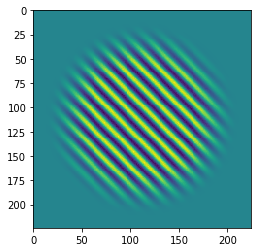

In [406]:
# Checking the reconstruction (inversion of pyramid step)

im_recon = pyr.recon_pyr()
plt.figure();
plt.pcolormesh(im_recon)
plt.axis('square')
plt.gca().invert_yaxis()

In [407]:
# Loading a set of actual images

from scipy import io
import h5py

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = io.loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from utils import load_nsd

n_samples = 5000
trn_stim_data = load_nsd.image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data
npix = images.shape[2]

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [408]:
# Doing this for a batch of NSD images now...

# choosing just one image here.
batch_size = 10
image_inds = np.arange(0,batch_size)
n_ori=8;
n_sf=4;
padding_mode='circular'

feature_extractor = steerable_pyramid_extractor(pyr_height=n_sf, n_ori = n_ori)
features_complex, features_real = feature_extractor(images[image_inds,:,:,:], to_torch=True, device=device)


time elapsed: 1.03287 s


In [360]:
len(features_complex)

4

In [357]:
import torch.nn as nn

class steerable_pyramid_extractor(nn.Module):
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(images[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)

            if ii==0:  
                fmaps_complex = []
                fmaps_real = []
                sf_reverse  = self.pyr_height
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],pyr.pyr_coeffs[sf_reverse,0].shape[1])))
                    fmaps_real.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],pyr.pyr_coeffs[sf_reverse,0].shape[1])))
                    
                fmaps_real.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
                fmaps_real.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))
                
            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     
                   
                    # take magnitude of complex number outputs
                    fmaps_complex[sf][ii,oo,:,:] = np.abs(pyr.pyr_coeffs[(sf_reverse,oo)])
                    
                    # also take real part of output
                    fmaps_real[sf][ii,oo,:,:] = np.real(pyr.pyr_coeffs[(sf_reverse,oo)])
            
            # Tack the residuals onto the end (real only since these are not complex numbers).
            fmaps_real[self.pyr_height][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_real[self.pyr_height+1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
                       
        elapsed = time.time() - t
        print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_real = [torch_utils._to_torch(fm, device=device) for fm in fmaps_real]
            fmaps_complex = [torch_utils._to_torch(fm, device=device) for fm in fmaps_complex]
        
        return fmaps_complex, fmaps_real, fmaps_residuals
        

In [323]:
pyr.pyr_coeffs[(0,1)].dtype
# fmaps = []
# for sf in range(pyr.num_scales):
#     maps = np.concatenate([np.expand_dims(pyr.pyr_coeffs[sf,oo], axis=2) for oo in range(n_ori)], axis=2)
#     fmaps.append(np.moveaxis(maps, [2], [0]))

dtype('complex128')

In [325]:
pyr.pyr_size[(0,1)]

(227, 227)

In [292]:
fmaps = []
for sf in np.arange(n_sf-1, -1, -1):
    maps = np.concatenate([np.expand_dims(pyr.pyr_coeffs[sf,oo], axis=2) for oo in range(n_ori)], axis=2)
    fmaps.append(maps)

In [294]:
fmaps[3].shape

(227, 227, 8)

In [287]:
pyr.pyr_coeffs['residual_highpass'].shape

(227, 227)

In [412]:
    
# now gabor method...
# choosing values here that will lead to ~ same size maps at each level.
sizevals=[npix]
i=npix
for d in range(n_sf-1):
    i=i/2
    sizevals.append(i)
cyc_per_stim = np.flipud(np.array(sizevals))/4.13

t = time.time()

_gaborizer = gabor_feature_extractor.Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode = padding_mode,
          crop=False).to(device)

maps = _gaborizer(torch_utils._to_torch(images[image_inds,:,:,:], device=device))
maps = [torch_utils.get_value(m) for m in maps]

elapsed = time.time() - t
print('time elapsed: %.5f s'%elapsed)
 

print(len(maps))

time elapsed: 0.09429 s
4
